# Grokking

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/grokking.ipynb)

In [1]:
%pip install devinterp seaborn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dataclasses import dataclass
from itertools import product
import logging
import os
from pathlib import Path
import time
from typing import Callable, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydantic import BaseModel
import seaborn as sns
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from tqdm import tqdm

from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import make_evaluate

from devinterp.optim.sgld import SGLD

%cd zoo
from data import ModularArithmeticConfig, ModularArithmetic
from transformer import TransformerConfig

sns.set_palette("deep")
sns.set_style("whitegrid")

CHECKPOINTS_PATH = Path("../checkpoints/grokking")
if not os.path.exists(CHECKPOINTS_PATH):
    os.makedirs(CHECKPOINTS_PATH)

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("deep")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("muted")[:3]

DEVICE = os.environ.get(
    "DEVICE",
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu",
)
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))


/home/svwin/aether/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/svwin/devinterp/examples/zoo


In [3]:
# Evals


def cross_entropy_last_token(outputs, targets, reduction="sum"):
    """
    Wrapper around cross entropy loss because we only care about the last number predicted.
    """
    # Only look at predictions of last numbers
    outputs = outputs[:, -1]

    # Compute individual and summed losses for final number
    logprobs = F.log_softmax(outputs.to(torch.float32), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=targets.unsqueeze(1), dim=-1)

    if reduction == "mean":
        loss = -torch.mean(prediction_logprobs)
    elif reduction == "sum":
        loss = -torch.sum(prediction_logprobs)
    else:
        raise ValueError("Invalid reduction argument.")

    return loss


def make_evals(trainset: ModularArithmetic, testset: ModularArithmetic, device: str):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

    def eval_loss_and_acc(model: nn.Module) -> Dict[str, float]:
        model.eval()

        results = {}

        for name, loader in zip(["train", "test"], [trainloader, testloader]):
            total = 0
            correct = 0

            for x, y in loader:
                x = x.to(device)
                y = y.to(device)

                with torch.no_grad():
                    y_hat = model(x)

                total += cross_entropy_last_token(y_hat, y, reduction="sum").item()
                correct += (
                    (y_hat[:, -1, :].max(dim=1).indices == y).sum().item()
                )  # argmax doesn't work for device=mps

            results[f"{name}/loss"] = total / len(loader.dataset)
            results[f"{name}/accuracy"] = correct / len(loader.dataset)

        return results

    return eval_loss_and_acc

In [29]:
@dataclass
class Learner:
    config: "GrokkingConfig"
    model: nn.Module
    dataset: torch.utils.data.Dataset
    loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Optimizer
    evals: Callable[[nn.Module], Dict[str, float]]


class GrokkingConfig(BaseModel):
    data: ModularArithmeticConfig
    model: TransformerConfig
    noise_level: float = 1.0
    batch_size: int = 256
    num_steps: int = 10000
    device: str = "cpu"
    lr: float = 1e-3
    betas: Tuple[float, float] = (0.9, 0.99)
    weight_decay: float = 1e-3

    class Config:
        arbitrary_types_allowed = True

    @property
    def num_training_examples(self):
        return int((self.data.modulus**2) * self.data.split)

    def create_model(self):
        return self.model.factory()

    def create_data(self):
        return self.data.factory_split()

    def create_learner(self):
        model = self.create_model()
        trainset, testset = self.create_data()
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=self.batch_size, shuffle=True
        )
        evals = make_evals(trainset, testset, self.device)
        optimizer = optim.AdamW(
            model.parameters(),
            lr=self.lr,
            betas=self.betas,
            weight_decay=self.weight_decay,
        )

        learner = Learner(self, model, trainset, trainloader, optimizer, evals)
        return learner


MODULUS = 113

learner_config = GrokkingConfig(
    data=ModularArithmeticConfig(operator="/", modulus=MODULUS, seed=0, split=0.4),
    model=TransformerConfig(
        d_vocab=MODULUS + 1,
        d_model=128,
        num_layers=2,
    ),
    lr=1e-3,
    weight_decay=0.2,
    betas=(0.9, 0.98),
    device=str(DEVICE),
)
learner = learner_config.create_learner()

In [30]:
def throttle(seconds):
    def decorator(func):
        last_called = 0

        def wrapper(*args, **kwargs):
            nonlocal last_called
            elapsed = time.monotonic() - last_called
            last_called = time.monotonic()

            if elapsed < seconds:
                return func(*args, **kwargs)

        return wrapper

    return decorator


def train(learner, num_log_ivl_steps=100, num_lin_ivl_steps=100):
    learner.model.to(learner.config.device)
    learner.model.train()

    evals = []


    num_steps = learner.config.num_steps
    logging_steps = set(np.linspace(0, num_steps, num_lin_ivl_steps).astype(int)) | set(
        np.logspace(0, num_steps, num_log_ivl_steps).astype(int)
    )

    def log(step):
        learner.model.eval()
        evals.append({"step": step, **learner.evals(learner.model)})
        # print(yaml.dump(evals[-1]))

        learner.model.train()



    def save_checkpoint(step):
        torch.save(learner.model.state_dict(), CHECKPOINTS_PATH / f"{step}.pt")

    step = -1
    epoch = -1

    pbar = tqdm(
        total=learner.config.num_steps,
        desc=f"Training...",
    )

    while step < learner.config.num_steps:
        torch.manual_seed(step)
        epoch += 1

        for x, y in learner.loader:
            step += 1
            x, y = x.to(learner.config.device), y.to(learner.config.device)
            learner.optimizer.zero_grad()
            y_hat = learner.model(x)
            loss = cross_entropy_last_token(y_hat, y)
            loss.backward()
            learner.optimizer.step()


            if step in logging_steps:
                log(step=step)
                save_checkpoint(step=step)

            pbar.update(1)

    if pbar:
        pbar.close()

    log(step=step)
    evals_df = pd.DataFrame(evals)
    evals_df.sort_values("step", inplace=True)

    return evals_df

In [31]:
train(learner, True)

Training...:  39%|███▉      | 3936/10000 [01:56<02:31, 40.03it/s]

In [ ]:
from devinterp.utils import default_nbeta
def make_rlct_evals(
    trainset: ModularArithmetic,
    num_draws=20,
    num_chains=5,
    num_cores=NUM_CORES,
    lr=1e-7,
    noise_level=1.0,
    localization=1.0,
    repeats=5,
):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
    optimizer_kwargs = dict(
        lr=lr,
        noise_level=noise_level,
        localization=localization,
        nbeta=default_nbeta(1024),
    )

    def eval_rlct(model: nn.Module):
        return estimate_learning_coeff_with_summary(
            model,
            trainloader,
            evaluate=make_evaluate(cross_entropy_last_token),
            optimizer_kwargs=optimizer_kwargs,
            num_draws=num_draws,
            num_chains=num_chains,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            cores=num_cores,
        )

    def eval_rlct_repeated(model):
        results = {f"rlct/{i}": eval_rlct(model)["llc/mean"] for i in range(repeats)}
        rlcts = list(results.values())
        results["rlct/mean"] = np.mean(rlcts).item()
        results["rlct/std"] = np.std(rlcts).item()

        return results

    return eval_rlct_repeated


def eval_rlcts_at_step(
    learner: Learner,
    step: int,
    num_draws=20,
    num_chains=5,
    num_cores=NUM_CORES,
    lr=1e-7,
    noise_level=1.0,
    localization=1.0,
    repeats=5,
):
    evals = []
    eval_rlcts = make_rlct_evals(
        learner.dataset,
        num_draws=num_draws,
        num_chains=num_chains,
        num_cores=num_cores,
        lr=lr,
        noise_level=noise_level,
        localization=localization,
        repeats=repeats,
    )

    checkpoint = torch.load(CHECKPOINTS_PATH / f"{step}.pt")
    learner.model.load_state_dict(checkpoint)
    evals.append(eval_rlcts(learner.model))

    return pd.DataFrame(evals)


def eval_rlcts_over_time(
    learner: Learner,
    steps: List[int],
    num_draws=20,
    num_chains=3,
    num_cores=NUM_CORES,
    lr=1e-7,
    noise_level=1.0,
    localization=1.0,
    repeats=5,
):
    evals = []
    eval_rlcts = make_rlct_evals(
        learner.dataset,
        num_draws=num_draws,
        num_chains=num_chains,
        num_cores=num_cores,
        lr=lr,
        noise_level=noise_level,
        localization=localization,
        repeats=repeats,
    )


    for step in steps:
        checkpoint = torch.load(CHECKPOINTS_PATH / f"{step}.pt")
        learner.model.load_state_dict(checkpoint)
        evals.append(eval_rlcts(learner.model))
        # print(yaml.dump(evals[-1]))


    return pd.DataFrame(evals)

## RLCT estimation hyperparameter tuning

In [ ]:
def unroll_grid(**hyperparams):
    hyperparams = {k: (v if isinstance(v, list) else [v]) for k, v in hyperparams.items()}

    keys, values = zip(*hyperparams.items())
    combinations = list(product(*values))
    return [dict(zip(keys, c)) for c in combinations]


def generate_rlct_hyperparam_grid_search(model, dataset, **hyperparams):
    grid = unroll_grid(**hyperparams)

    for _hyperparams in grid:
        evals = make_rlct_evals(dataset, **_hyperparams)(model)
        yield _hyperparams, evals


def rlct_hyperparam_grid_search(model, dataset, **hyperparams):
    results = []

    for _hyperparams, evals in generate_rlct_hyperparam_grid_search(model, dataset, **hyperparams):
        results.append({**_hyperparams, **evals})
        # print(yaml.dump(results[-1]))

    return pd.DataFrame(results)


# lr, num_draws, noise_level, localization
grid_search = rlct_hyperparam_grid_search(
    learner.model,
    dataset=learner.dataset,
    lr=[1e-7, 1e-5, 1e-3],
    num_draws=[300, 1000],
    noise_level=[1.0],
    num_chains=1,
    repeats=2,
    localization=[100.0],
)

[cpu] Chain 0:   0%|          | 0/300 [00:00<?, ?it/s, grad_accum_steps=0]

[cpu] Chain 0: 100%|██████████| 1000/1000 [00:42<00:00, 23.30it/s, grad_accum_steps=0]


In [ ]:
# torch.save(grid_search, "../data/grokking-rlct-sweep.pt")

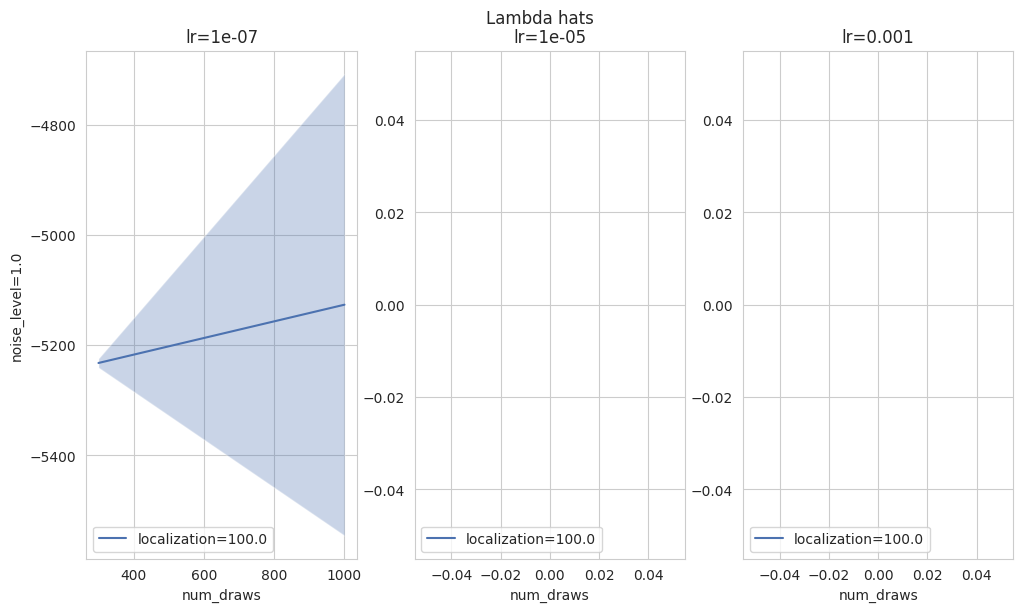

In [ ]:
NUM_PARAMS = sum(map(lambda x: x.numel(), learner.model.parameters()))


def plot_rlct_grid(
    df,
    col_axis: str,
    row_axis: str,
    label_axis: str,
    x_axis: str,
    title: str,
    logscale: bool = True,
    inset=False,
    figsize=(10, 6),
):
    cols = df[col_axis].unique()
    rows = df[row_axis].unique()
    labels = df[label_axis].unique()
    xs = df[x_axis].unique()

    # Define the colors for each w value
    colors = [PRIMARY, SECONDARY, TERTIARY]

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(len(rows), len(cols), figsize=figsize)

    if len(rows) == 1 and len(cols) == 1:
        axes = np.array([[axes]])
    elif len(rows) == 1:
        axes = axes.reshape(1, -1)
    elif len(cols) == 1:
        axes = axes.reshape(-1, 1)

    fig.suptitle(title)
    fig.tight_layout()

    # Iterate through the unique gammas
    for i, col in enumerate(cols):
        for j, row in enumerate(rows):
            axes[j, 0].set_ylabel(f"{row_axis}={row}")
            axes[0, i].set_title(f"{col_axis}={col}")
            axes[-1, i].set_xlabel(x_axis)

            ax = axes[j, i]

            for k, label in enumerate(labels):
                data = df[(df[col_axis] == col) & (df[label_axis] == label) & (df[row_axis] == row)]
                color = colors[k]

                rlct_mean = data["rlct/mean"]
                rlct_std = data["rlct/std"]

                if rlct_mean.max() > NUM_PARAMS:
                    continue

                # Plot the training error against the number of steps
                ax.plot(data[x_axis], rlct_mean, color=color, label=f"{label_axis}={label}")
                ax.fill_between(xs, rlct_mean - rlct_std, rlct_mean + rlct_std, alpha=0.3)

            # if logscale:
                # ax.set_yscale("log")
                # ax.set_xscale("log")

            ax.legend(loc="lower left")

    plt.show()


# lr, num_draws, noise_level, localization
plot_rlct_grid(
    grid_search,
    col_axis="lr",
    row_axis="noise_level",
    x_axis="num_draws",
    label_axis="localization",
    title="Lambda hats",
)

In [ ]:
checkpoint_steps = sorted(
    list(
        map(
            lambda filename: int(str(filename).split("/")[-1].split(".")[0]),
            CHECKPOINTS_PATH.glob("*.pt"),
        )
    )
)
evals_over_time = eval_rlcts_over_time(
    learner,
    checkpoint_steps,
    num_draws=1000,
    num_chains=1,
    num_cores=NUM_CORES,
    lr=1e-6,
    noise_level=1.0,
    weight_decay=3e-7,
    elasticity=100.0,
    repeats=5,
    pbar=True,
)

TypeError: eval_rlcts_over_time() got an unexpected keyword argument 'weight_decay'